# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**

Набор данных находится в файле /datasets/autos.csv.

**Признаки**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
- Целевой признак

**Цедевой признак**
- Price — цена (евро)

<h1>Содержание<span class="tocSkip"></span></h1>

## Подготовка данных

### Обзор данных

In [1]:
# импортируем библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import catboost as cb
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error as mse
from catboost import CatBoostRegressor, Pool


# зафиксируем псевдослучайность для всех используемых в проекте алгоритмов
rnd_state = 12345

In [2]:
# загрузим данные
data = pd.read_csv('/datasets/autos.csv')

In [3]:
# изучим файл
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
print(data.shape)

(354369, 16)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<div style="border:solid green 2px; padding: 20px">

**Вывод:**    
    
Данные загружены и изучены.

Набор данных находится в файле /datasets/autos.csv. 
    
**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя    

**Целевой признак**
    
Price — цена (евро)    
    
    
Продолжим анализ и обработку данных.    
</div>       

### Анализ и обработка данных

**Анализ и обработка категориальных данных:**

In [7]:
# статистика по категориальным переменным
data.describe(include=['object'])

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


In [8]:
# проверим пропуски
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [9]:
# проверим данные на наличие дубликатов
data.duplicated().sum()

4

- Обнаружены пропуски в категориальных признаках. Есть два варианта избавиться от пропусков:
    1. удалить
    2. заменить на подходящее значение

При удалении можем потерять до 20% данных - это очень много (есть риск искажения данных), лучше заменим их на Nan.
- Обнаружены дубликаты - их немного, удалим.

In [10]:
# заполним пропуски в категориальных признаках
columns_isnull = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']
data[columns_isnull] = data[columns_isnull].fillna('Nan')

# проверим заполнение
data.isnull().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [11]:
# удалим дубликаты
data = data.drop_duplicates().reset_index(drop=True)

# проверим удаление 
data.duplicated().sum()

0

*Удалим столбцы, которые не потребуются для дальнейшего анализа:*

In [12]:
columns_drop = ['DateCrawled', 'LastSeen', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'RegistrationMonth']
data = data.drop(columns=columns_drop, axis = 1)

___
**Анализ и обработка количественных данных:**

In [13]:
# проверка аномалий в числовых признаках
columns_numeric = ['Price', 'RegistrationYear', 'Power', 'Kilometer']

def numeric(data, columns_numeric):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    for column, ax in zip(columns_numeric, axes.ravel()):
        ax.set_title(column)
        sns.distplot(data[column], ax=ax)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    for column, ax in zip(columns_numeric, axes.ravel()):
        ax.set_title(column)
        sns.boxplot(data[column], ax=ax)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

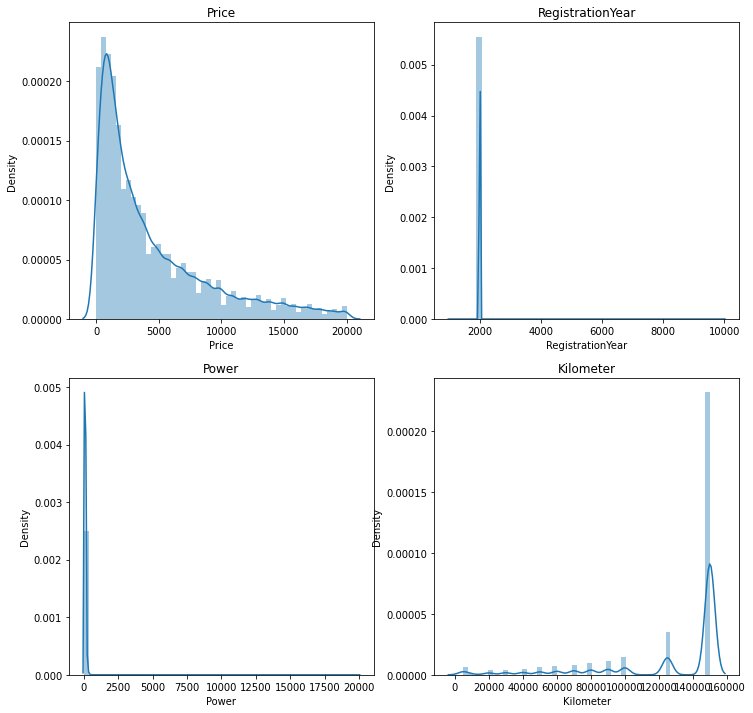

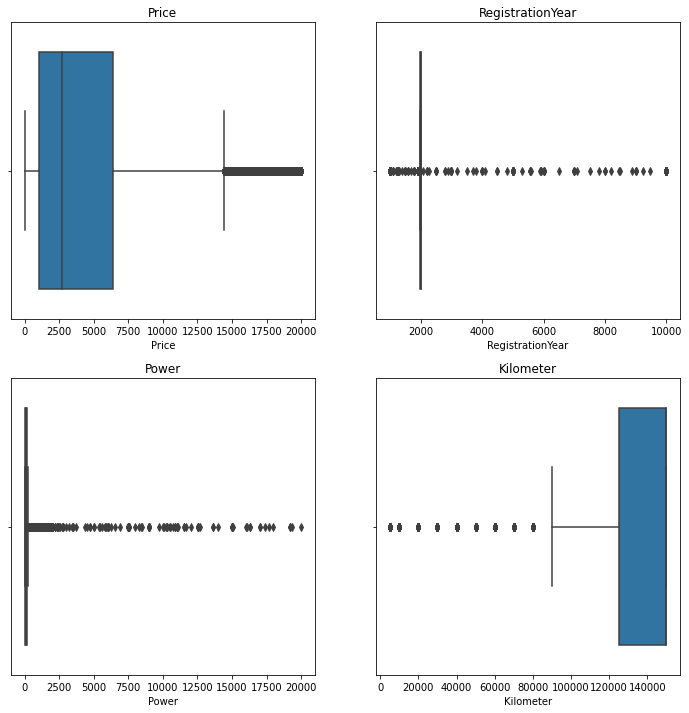

In [14]:
numeric(data, columns_numeric)

- Обнаружены нулевые значения в стоимости - будем их использовать в тестовой выборке. 
- Некорректные значения в дате регистрации автомобиля.
- Некорректные значения мощности, есть аномальные выбросы.
- Столбец 'Kilometer' имеет достаточно реальные значения.
___________________________________________________

`Price`

В колонке стоимости автомобиля 'Price' будем считать аномальными (некорректными) значения ниже 200 евро, удалять не будем, приравняем к нулю и будем использовать в тестовой выборке.

In [15]:
# удалим аномалные значения в колонке Price
data = data.loc[(data['Price']<=200)]

______
`RegistrationYear`

Посмотрим также на процент данных с ошибками в 'RegistrationYear'

In [16]:
print("Процент данных с ошибками по годам: {:.2%}".format(data
                                                          .query('RegistrationYear<1950 or RegistrationYear>2019')
                                                          .shape[0] / data.shape[0]))

Процент данных с ошибками по годам: 0.81%


Установим границы, в которых может находится значение этого столбца. Если посмотреть на дату выгрузки данных, то будет видно, что мы должны ограничиваться 2016 годом. Год регистрации не может быть больше 2016, и не может быть меньше 1950. Все показания выше или ниже этих значений удалим.

In [17]:
# удалим аномальные значение в столбце RegistrationYear
data = data.loc[(data['RegistrationYear']>1950) & (data['RegistrationYear']<2016)]

____
`Power`

В 'Power' присутствуют аномальные значения (20000 лошадиных сил). Однако автомобилей с акой мощьностью не существует.
На данный момент чемпионом считается американский карьерный самосвал Caterpillar 797F — огромная машина, мощностью 4000 лошадиных сил. Установим ограничения мощности до 4000. 

In [18]:
# количество автомобилей с нулевой мощностью 
data[data['Power']==0].shape[0]

6243

Также присутствуют автомобили с нулевым значением мощности двигателя. Установим огранияение от 60 лошадиных сил, как минимальная наиболее распроспространенная мощность (в том числе для раритетных автомобилей). 

In [19]:
# удалим аномальные значение в столбце Power
data = data.loc[(data['Power']>60) & (data['Power']<4000)]

In [20]:
data.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,-0.162494,-0.145082,0.058822
RegistrationYear,-0.162494,1.000000,0.092184,-0.095311
Power,-0.145082,0.092184,1.000000,-0.048877
Kilometer,0.058822,-0.095311,-0.048877,1.000000


<div style="border:solid green 2px; padding: 20px">
    
**Вывод:**
    
Представленные данные состоят из 16 признаков и 354369 объектов. Целевым признаком, в данном случае, является Price — цена (евро). Зафиксировали псевдослучайность для всех используемых в проекте алгоритмов.
    
    КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ:
- Пропуски обнаружены только в категорийных признаках, поэтому заменили их на Nan.
- Дубликаты удалили.
- Удалили столбцы: 'DateCrawled', 'LastSeen', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'RegistrationMonth' ненужные данные для дальнейшего анализа.

    КОЛИЧЕСТВЕННЫЕ ПРИЗНАКИ:
- Провели анализ аномалий количественных признаков в столбцах: Price, RegistrationYear и Power. В столбце Kilometer каких-то аномальных признаков не обнаружено.
- Данные были очищены от выбросов.    
    
</div>    

## Обучение моделей

- Для обучения будем использовать 3 модели: CatBoost, LightGBM, Линейная регрессия.
- Разделим исходные данные на выборки.
- Для моделей CatBoost, LightGBM кодировать данные не будем, т.к. эти модели работают с категориальными признаками напрямую.
- Для линейнейной регресии закодируем признаки методом OHE.

___

data_ohe = pd.get_dummies(data, drop_first=True)
target = data_ohe['Price']
features = data_ohe.drop('Price', axis=1)

data_train, data_valid = train_test_split(data_ohe, test_size=0.2, random_state=rnd_state)
data_valid, data_test = train_test_split(data_valid , test_size=0.2, random_state=rnd_state)

features_train = data_train.drop(columns=['Price'])
target_train = data_train['Price']

features_valid = data_valid.drop(columns=['Price'])
target_valid = data_valid['Price']

features_test = data_test.drop(columns=['Price'])
target_test = data_test['Price']

In [21]:
# OHE кодирование для линейной регрессии
data_ohe = data.copy()
data_ohe = pd.get_dummies(data_ohe, drop_first=True)

# рахделим закодированные данные на выборки
data_train, data_valid = train_test_split(data_ohe, test_size=0.4, random_state=rnd_state)
data_valid, data_test = train_test_split(data_valid, test_size=0.5, random_state=rnd_state)

In [22]:
features_train_1 = data_train.drop(columns=['Price'])
target_train_1 = data_train['Price']

features_valid_1 = data_valid.drop(columns=['Price'])
target_valid_1 = data_valid['Price']

features_test_1 = data_test.drop(columns=['Price'])
target_test_1 = data_test['Price']

print("Размер выборок:")
print(features_train_1.shape)
print(features_valid_1.shape)
print(features_test_1.shape)

Размер выборок:
(4614, 262)
(1538, 262)
(1538, 262)


In [23]:
# разделим предобработанные данные на выборки без кодировки для CatBoost, LightGBM
data_original = data.copy()

# поменяем тип данных на category
data_original = data_original.astype({'VehicleType':'category',
                                      'Gearbox':'category',
                                      'Model':'category',
                                      'FuelType':'category',
                                      'Brand':'category',
                                      'NotRepaired':'category'})

# вынесем категориальные признаки в отдельную переменнную
cat = ['VehicleType','Gearbox', 'Model','FuelType', 'Brand','NotRepaired']

data_train, data_valid = train_test_split(data_original, test_size=0.4, random_state=rnd_state)
data_valid, data_test = train_test_split(data_valid, test_size=0.5, random_state=rnd_state)

features_train_2 = data_train.drop(columns=['Price'])
target_train_2 = data_train['Price']

features_valid_2 = data_valid.drop(columns=['Price'])
target_valid_2 = data_valid['Price']

features_test_2 = data_test.drop(columns=['Price'])
target_test_2 = data_test['Price']

print("Размер выборок:")
print(features_train_2.shape)
print(features_valid_2.shape)
print(features_test_2.shape)

Размер выборок:
(4614, 9)
(1538, 9)
(1538, 9)


Напишем функцию, которая на вход принмает модель и датасеты, возвращает время обучения, время предсказания и rmse

In [24]:
def model_eval(model, features_train, target_train, features_test, target_test):
    
    start = time.time()    
    model.fit(features_train, target_train)
    training_time = time.time() - start
    
    start = time.time()  
    target_pred = model.predict(features_test)
    predict_time = time.time() - start

    return training_time, predict_time

In [25]:
# LinearRegression

model_lr = LinearRegression()

start_time = time.time()
model_lr.fit(features_train_1, target_train_1)

training_time_lr = model_eval(model_lr, features_train_1, target_train_1, features_test_1, target_test_1)

predict_lr = pd.DataFrame(model_lr.predict(features_valid_1))
score_lr = mean_squared_error(target_valid_1, predict_lr) ** 0.5

print("RMSE LinearRegression:", score_lr)
print("Время обучения LinearRegression:", training_time_lr)

RMSE LinearRegression: 64.64363465460414
Время обучения LinearRegression: (1.9024033546447754, 0.10844182968139648)


In [26]:
# LGBMRegressor

from collections import defaultdict
d = defaultdict(list)

lgbm_model = LGBMRegressor(num_leaves=31, learning_rate=0.05, n_estimators=200, random_state=rnd_state)
start_time = time.time()
lgbm_model.fit(features_train_2, target_train_2)

training_time_lgbm = model_eval(lgbm_model, features_train_2, target_train_2, features_test_2, target_test_2)

predict_lgbm = pd.DataFrame(lgbm_model.predict(features_valid_2))
score_lgbm = mean_squared_error(target_valid_2, predict_lgbm) ** 0.5

print("RMSE LGBMRegressor:", score_lgbm)
print("Время обучения LGBMRegressor:", training_time_lgbm)

RMSE LGBMRegressor: 60.05639547375019
Время обучения LGBMRegressor: (13.494638681411743, 0.10957169532775879)


In [27]:
# CatBoostRegressor

cat_model = CatBoostRegressor(loss_function="RMSE", iterations=50, random_state=rnd_state, cat_features=cat)
start_time = time.time()

cat_model.fit(features_train_2, target_train_2, verbose=10)

training_time_cat = model_eval(cat_model, features_train_2, target_train_2, features_test_2, target_test_2)

predict_cat = cat_model.predict(features_valid_2)
score_cat = mean_squared_error(target_valid_2, predict_cat) ** 0.5

print("RMSE CatBoostRegressor:", score_cat)
print("Время обучения CatBoostRegressor:", training_time_cat)

Learning rate set to 0.5
0:	learn: 66.9792812	total: 55.5ms	remaining: 2.72s
10:	learn: 61.4444531	total: 116ms	remaining: 411ms
20:	learn: 60.0989642	total: 173ms	remaining: 239ms
30:	learn: 58.9408386	total: 233ms	remaining: 143ms
40:	learn: 57.8236478	total: 294ms	remaining: 64.6ms
49:	learn: 56.8151129	total: 348ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 66.9792812	total: 8.12ms	remaining: 398ms
1:	learn: 64.6090910	total: 14.9ms	remaining: 357ms
2:	learn: 63.5467788	total: 22.1ms	remaining: 345ms
3:	learn: 63.2515175	total: 29ms	remaining: 334ms
4:	learn: 62.7671187	total: 36.4ms	remaining: 328ms
5:	learn: 62.4428616	total: 43.9ms	remaining: 322ms
6:	learn: 62.3662715	total: 47.8ms	remaining: 294ms
7:	learn: 62.0695078	total: 56.6ms	remaining: 297ms
8:	learn: 61.9006730	total: 64.9ms	remaining: 296ms
9:	learn: 61.5862682	total: 72.6ms	remaining: 291ms
10:	learn: 61.4444531	total: 80.4ms	remaining: 285ms
11:	learn: 61.3339108	total: 87.9ms	remaining: 278ms
12:	learn: 61.3

**Вывод:**
- Применили для категориальных признаков метод OHE
- Рассмотрели три алгоритма классификации: CatBoostRegressor, LGBMRegressor, LinearRegression
- Модель "CatBoostRegressor" наиболее подходящая для решения дальнейшей задачи

## Анализ моделей

In [28]:
data_time = pd.Series({'LinearRegression': training_time_lr,
                           'LightGBM': training_time_lgbm,
                           'CatBoost': training_time_cat}) 

data_time

LinearRegression     (1.9024033546447754, 0.10844182968139648)
LightGBM             (13.494638681411743, 0.10957169532775879)
CatBoost            (1.4236631393432617, 0.003799915313720703)
dtype: object

In [29]:
data_score = pd.Series({'LinearRegression': score_lr,
                           'LightGBM': score_lgbm,
                           'CatBoost': score_cat}) 

data_score

LinearRegression    64.643635
LightGBM            60.056395
CatBoost            61.033514
dtype: float64

Проверим выбранную модель "CatBoostRegressor" на тестовой выборке:

In [30]:
features_test_2 = data_original.drop('Price', axis=1)
target_test_2 = data_original['Price']

cat_model = CatBoostRegressor(loss_function="RMSE", iterations=50, random_state=rnd_state, cat_features=cat)
start_time = time.time()

cat_model.fit(features_train_2, target_train_2, cat_features=cat, verbose=10)

training_time_cat = model_eval(cat_model, features_train_2, target_train_2, features_test_2, target_test_2)

predict_cat = cat_model.predict(features_test_2)
score_cat = mean_squared_error(target_test_2, predict_cat ) ** 0.5

print("RMSE CatBoostRegressor:", score_cat)
print("Время обучения CatBoostRegressor:", training_time_cat)

Learning rate set to 0.5
0:	learn: 66.9792812	total: 7.99ms	remaining: 392ms
10:	learn: 61.4444531	total: 66.9ms	remaining: 237ms
20:	learn: 60.0989642	total: 124ms	remaining: 171ms
30:	learn: 58.9408386	total: 185ms	remaining: 113ms
40:	learn: 57.8236478	total: 245ms	remaining: 53.8ms
49:	learn: 56.8151129	total: 299ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 66.9792812	total: 8.36ms	remaining: 410ms
1:	learn: 64.6090910	total: 15.2ms	remaining: 364ms
2:	learn: 63.5467788	total: 21.9ms	remaining: 343ms
3:	learn: 63.2515175	total: 28.3ms	remaining: 326ms
4:	learn: 62.7671187	total: 34.4ms	remaining: 310ms
5:	learn: 62.4428616	total: 40.5ms	remaining: 297ms
6:	learn: 62.3662715	total: 43.7ms	remaining: 268ms
7:	learn: 62.0695078	total: 49.6ms	remaining: 261ms
8:	learn: 61.9006730	total: 55.6ms	remaining: 253ms
9:	learn: 61.5862682	total: 61.7ms	remaining: 247ms
10:	learn: 61.4444531	total: 67.8ms	remaining: 241ms
11:	learn: 61.3339108	total: 73.7ms	remaining: 233ms
12:	learn: 6

<div style="border:solid green 2px; padding: 20px">
    
**Вывод:**

Рассмотрели три модели для определения стоимости: CatBoostRegressor, LGBMRegressor, LinearRegression по параметрам:

- качество предсказания;
- скорость предсказания;
- время обучения.

Наиболее подходящей является модель CatBoostRegressor, она показала лучшие результаты по этим параметрам.
</div> 